# Predicting hourly bike rentals using three machine learning techniques

In this project, we compare linear regression, decision trees and random forests techniques to the same dataset of bike rentals, available [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). Let's begin by importing to data into a pandas dataframe. Each row represents one hour of one day. Our target column will be 'cnt', the number of bike rentals during that hour. We will do feature selection based on the correlation factors. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

rentals = pd.read_csv('bike_rental_hour.csv')
rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The hour column is a categorical column that will split into too many columns once turned into a dummy. Let's separate the day into four parts instead.

In [2]:
def assign_hour_label(hour):
    if 6 < hour <= 12:
        code = 1 # morning
    elif 12 < hour <= 18:
        code = 2 # afternoon
    elif 18 < hour <= 24:
        code = 3 # evening    
    elif 0 <= hour <= 6:
        code = 4 #night
    else:
        raise RuntimeError('hour out of bounds')
    return code

rentals['hour_label'] = rentals['hr'].apply(assign_hour_label).astype(int)
rentals['hour_label']

0        4
1        4
2        4
3        4
4        4
        ..
17374    3
17375    3
17376    3
17377    3
17378    3
Name: hour_label, Length: 17379, dtype: int32

Let's make dummies out of the categorical columns. This is only to improve the linear regression model - tree-based models will not use the dummies.

In [3]:
cat_cols = ['season', 'hour_label', 'weekday', 'weathersit']
for col in cat_cols:
    dum = pd.get_dummies(rentals[col], prefix=col)
    rentals = pd.concat([rentals, dum], axis=1)
    rentals = rentals.drop(col, axis=1)
rentals.head()

,instant,dteday,yr,mnth,hr,holiday,workingday,temp,atemp,hum,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,2011-01-01,0,1,0,0,0,0.24,0.2879,0.81,...,0,0,0,0,0,1,1,0,0,0
1,2,2011-01-01,0,1,1,0,0,0.22,0.2727,0.80,...,0,0,0,0,0,1,1,0,0,0
2,3,2011-01-01,0,1,2,0,0,0.22,0.2727,0.80,...,0,0,0,0,0,1,1,0,0,0
3,4,2011-01-01,0,1,3,0,0,0.24,0.2879,0.75,...,0,0,0,0,0,1,1,0,0,0
4,5,2011-01-01,0,1,4,0,0,0.24,0.2879,0.75,...,0,0,0,0,0,1,1,0,0,0


Feature seelction of the linear regression model will depend on the correlations of each columns with the target column of 'cnt'.

In [4]:
correlations = rentals.corr()['cnt'].abs().sort_values()
correlations

weekday_6       0.001692
weekday_3       0.003746
weekday_2       0.003969
weathersit_4    0.008340
hour_label_3    0.010376
weekday_1       0.012860
weekday_5       0.015034
weekday_4       0.015653
weekday_0       0.027118
season_4        0.029421
workingday      0.030284
holiday         0.030927
weathersit_2    0.046902
season_2        0.060692
windspeed       0.093234
weathersit_1    0.117478
mnth            0.120638
weathersit_3    0.128034
season_3        0.151621
hour_label_1    0.153617
season_1        0.245456
yr              0.250495
instant         0.278379
hum             0.322911
hr              0.394071
atemp           0.400929
temp            0.404772
hour_label_2    0.430665
hour_label_4    0.550679
casual          0.694564
registered      0.972151
cnt             1.000000
Name: cnt, dtype: float64

We will choose the linear regression training features based on the correlation factor of a given column with the target column 'cnt'. Only columns with a correlation factor higher than 0.2 will be selected (arbitrary).

In [5]:
# Drop 'hr' column hour_label yields better information, and 'cnt' because it is our target.
correlations.drop(['hr', 'cnt'], inplace=True)
# Drop 'casual' and 'registered' columns because they directly sum to our target. We want our algorithm to be blind to that data.
correlations.drop(['casual', 'registered'], inplace=True)
features = correlations[correlations > 0.2].index
features

Index(['season_1', 'yr', 'instant', 'hum', 'atemp', 'temp', 'hour_label_2',
       'hour_label_4'],
      dtype='object')

To split the dataset into training and testing, we will use a simple 80% train and 20% test split.

In [47]:
train = rentals.sample(frac=0.8)
test = rentals.loc[~rentals.index.isin(train.index)]

## Linear Regression
Let's begin with a simple linear regression model. All models used in this project are based off scikit-learn. 

In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])

Let's explore the distribution of 'cnt' in order to choose a good error metric.

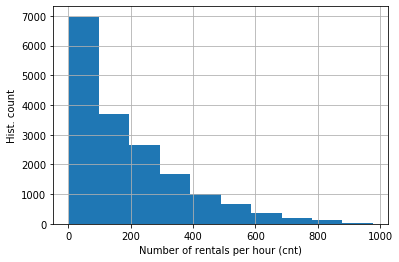

In [8]:
rentals['cnt'].hist()
plt.xlabel('Number of rentals per hour (cnt)')
plt.ylabel('Hist. count')
plt.show()

It is a lot more frequent to see low number of rentals than high number of rentals per hour. From this distribution, we desire a metric that penalizes big errors. The selected metric will be mean_squared_error

In [9]:
from sklearn.metrics import mean_squared_error

rmse_linear = np.sqrt(mean_squared_error(test['cnt'], predictions))
rmse_linear

127.09103520975522

## Decision tree
Let's compare our RMSE of 125.3, obtained from a Linear Regression model, to a Decision Tree-based model.

In [40]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(min_samples_leaf=5, max_depth=7)
dtr.fit(train[features], train['cnt'])

# Train predictions
predictions = dtr.predict(train[features])
rmse_tree_train = np.sqrt(mean_squared_error(train['cnt'], predictions))
# Test predictions
predictions = dtr.predict(test[features])
rmse_tree_test = np.sqrt(mean_squared_error(test['cnt'], predictions))

rmse_tree_train, rmse_tree_test

(112.19589791992223, 117.35706477681676)

We have managed to reduce the RMSE to 117.34. There is a little bit of overfitting, since the training RMSE is lower than the test RMSE, but it is has been minimized already using min_samples_leaf and max_depth parameters.

## Random Forest

A random forest is a random assortment of decision trees, which takes the best qualities of each tree. Let's witness the effect that using a random forest has over using a single decision tree.


In [46]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, bootstrap=True, min_samples_leaf=5, max_depth=7)
rfr.fit(train[features], train['cnt'])

# Train predictions
predictions = rfr.predict(train[features])
rmse_forest_train = np.sqrt(mean_squared_error(train['cnt'], predictions))
# Test predictions
predictions = rfr.predict(test[features])
rmse_forest_test = np.sqrt(mean_squared_error(test['cnt'], predictions))

rmse_forest_train, rmse_forest_test

(111.12311539882047, 116.16989831594488)

We could successfully reduced RMSE further using a random forest.

# Conclusion

In this project, we explored three different machine learning techniques: linear regression, decision tree, and random forest. For our application of predicting the number of bike rentals at a given hour and date, the random forest algorithm produced the lowest error. Tree-based models often produce more accurate results than linear regression, and random forest is better than a single decision tree because it learns from multiple different trainings and averages, leaving less effect to luck. It is important to note that another problem could have resulted in linear regression being the optimal technique, especially if it has higher correlation factors with the target.